# Lambert W x Gamma Regression (California Housing Data)

This is in comparison to the Gamma Regression notebook for the same dataset.  The Lambert W x Gamma distribution adds an additional tail parameter for adding heavier weight to larger values in the target variable (compared to what a Gamma distribution could afford).

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/XGBoostLSS/blob/master/docs/examples/Gamma_Regression_CaliforniaHousing.ipynb)

# Imports

In [1]:
from xgboostlss.model import *
from xgboostlss.distributions.LambertWGamma import *
from xgboostlss.distributions.LambertWWeibull import *


from sklearn import datasets
from sklearn.model_selection import train_test_split
import multiprocessing
import seaborn as sns

# Data

In [2]:
n_cpu = multiprocessing.cpu_count()

housing_data = datasets.fetch_california_housing()
X, y = housing_data["data"], housing_data["target"]
feature_names = housing_data["feature_names"]

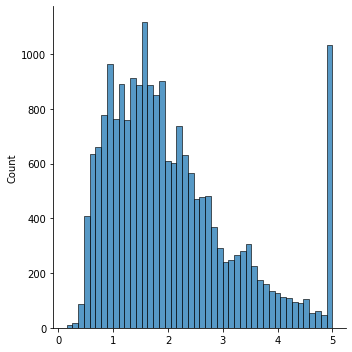

In [3]:
sns.displot(y)

5.0
(20640, 8)
(19648, 8)


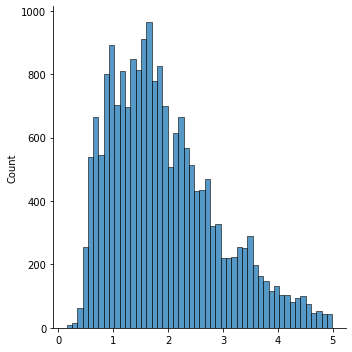

In [4]:
cutoff_value_y = 5.0 #y.max()
mask = (y < cutoff_value_y)
print(cutoff_value_y)
print(X.shape)
y = y[mask]
X = X[mask]
print(X.shape)
sns.displot(y)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [6]:
# Specifies Gamma distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gamma for an overview.
xgblss = XGBoostLSS(
     SkewLambertWWeibull(stabilization="L2",     # Options are "None", "MAD", "L2".
          response_fn="softplus",      # Function to transform the concentration and rate parameters, e.g., "exp" or "softplus".
          loss_fn="nll"           # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
         )
)

# Hyper-Parameter Optimization

Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    - Float/Int sample_type
        - {"param_name": ["sample_type", low, high, log]}
            - sample_type: str, Type of sampling, e.g., "float" or "int"
            - low: int, Lower endpoint of the range of suggested values
            - high: int, Upper endpoint of the range of suggested values
            - log: bool, Flag to sample the value from the log domain or not
        - Example: {"eta": "float", low=1e-5, high=1, log=True]}

    - Categorical sample_type
        - {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            - sample_type: str, Type of sampling, either "categorical"
            - choice1, choice2, choice3, ...: str, Possible choices for the parameter
        - Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    - For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        - {"param_name": ["none", [value]]},
            - param_name: str, Name of the parameter
            - value: int, Value of the parameter
        - Example: {"gpu_id": ["none", [0]]}

Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are specified, max_depth is not used when gblinear is sampled, since it has no such argument.

In [7]:
param_dict = {
    "eta":              ["float", {"low": 0.01,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 3,      "high": 8,    "log": False}],
    "gamma":            ["float", {"low": 0.01,   "high": 10,    "log": True}],
    "subsample":        ["float", {"low": 0.5,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1,   "high": 10,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=2,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=6,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=2                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-11-29 10:57:17,077] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization


   0%|          | 00:00/06:00

[I 2023-11-29 10:59:50,618] Trial 0 finished with value: 5450.4799805 and parameters: {'eta': 0.07447144904083071, 'max_depth': 3, 'gamma': 0.44564335346608885, 'subsample': 0.7176611963091384, 'colsample_bytree': 0.5362942416699912, 'min_child_weight': 2.1396109951447015, 'booster': 'gbtree'}. Best is trial 0 with value: 5450.4799805.
[I 2023-11-29 11:01:35,286] Trial 1 finished with value: 5526.0944825 and parameters: {'eta': 0.025662399883680794, 'max_depth': 6, 'gamma': 0.07924356787008145, 'subsample': 0.6334136375514333, 'colsample_bytree': 0.696907066215436, 'min_child_weight': 3.3817546376363623, 'booster': 'gbtree'}. Best is trial 0 with value: 5450.4799805.
[I 2023-11-29 11:03:39,228] Trial 2 finished with value: 5610.623535000001 and parameters: {'eta': 0.018584885538668383, 'max_depth': 6, 'gamma': 0.03575358516942407, 'subsample': 0.8926675739083367, 'colsample_bytree': 0.8831802341115911, 'min_child_weight': 3.1205908976574768, 'booster': 'gbtree'}. Best is trial 0 with v

# Model Training

In [8]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [9]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.5, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [10]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.007809,1.235342,0.874906,0.900597,0.547831,0.242772,0.789774,1.106063,1.043332,1.325357,...,0.555277,0.746135,0.555135,1.098487,0.643334,0.935985,0.379075,1.057009,1.030305,0.897507
1,3.658527,2.723713,5.536567,3.088175,4.355576,1.740651,3.961846,4.032202,2.744403,1.503014,...,3.466530,3.666581,2.997201,2.076194,2.657675,5.037623,3.914808,5.125331,3.301433,1.261261
2,1.634244,0.809295,1.473576,1.160867,0.855564,1.834495,1.380079,1.042527,1.391662,1.890290,...,1.143005,1.402494,1.017928,1.147277,1.913019,1.002491,1.610939,1.097776,1.227601,0.713008
3,3.227213,1.807588,2.260576,1.715006,2.369260,3.549269,2.517004,2.780411,2.007952,0.924531,...,1.143970,1.543936,1.782716,2.585397,2.561285,1.475336,2.706069,1.485228,1.359753,0.984709
4,1.536601,1.756086,1.436289,2.239838,1.347004,0.863361,1.312311,0.626823,1.840655,1.788874,...,0.725320,1.454208,1.206682,0.721680,1.677201,1.506297,1.188018,1.893225,1.099573,1.430312


In [11]:
pred_quantiles.head()

,quant_0.05,quant_0.5,quant_0.95
0,0.469938,0.919875,1.422639
1,1.081901,2.748145,4.776156
2,0.676726,1.302429,1.965329
3,0.933556,2.148475,3.616999
4,0.584506,1.339902,2.175544


In [13]:
pred_params.head()

,concentration,scale,skewweight,median,mean,mean_sample
0,6.176802,0.463306,0.139699,0.919875,0.430506,0.935253
1,6.511069,0.696405,0.249500,2.748145,0.648955,2.808966
2,6.739511,0.558058,0.153514,1.302429,0.520991,1.306593
3,6.449971,0.664039,0.220071,2.148475,0.618481,2.200891
4,6.423474,0.514250,0.181082,1.339902,0.478862,1.351978


In [14]:
# Gamma
#pred_params["mean"] = pred_params["concentration"] / pred_params["rate"]
#pred_params["var"] = pred_params["mean"] / pred_params["rate"]

# Weibull
import scipy.special
pred_params["median"] = pred_quantiles["quant_0.5"]
pred_params["mean"] = pred_params["scale"] * scipy.special.gamma(1. + 1 / pred_params["concentration"])# / pred_params["rate"]
pred_params["mean_sample"] = pred_samples.mean(axis=1)

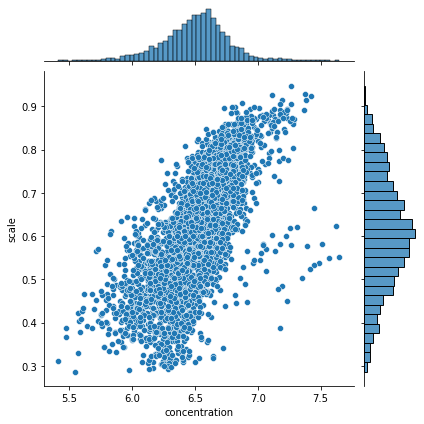

In [15]:
sns.jointplot(data=pred_params, x="concentration", y="scale")

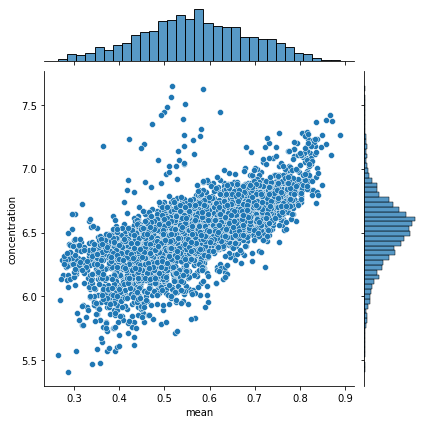

In [16]:
sns.jointplot(data=pred_params, x="mean", y="concentration")

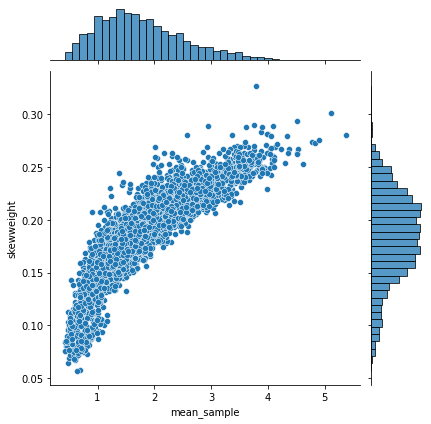

In [17]:
sns.jointplot(data=pred_params, x="mean_sample", y="skewweight")

<Axes: xlabel='mean_sample'>

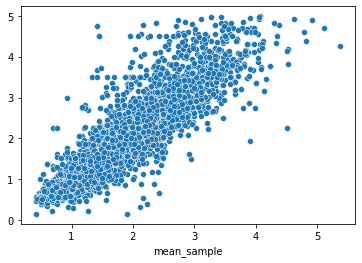

In [18]:
sns.scatterplot(x=pred_params["mean_sample"], y=y_test)

# SHAP Interpretability

In [ ]:
# Partial Dependence Plot
pdp_df = pd.DataFrame(X_train, columns=feature_names)
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="concentration",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

In [ ]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature=feature_names[0],
            plot_type="Partial_Dependence")

In [ ]:
# Feature Importance
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            plot_type="Feature_Importance")

In [ ]:
xgblss.plot(pdp_df.sample(1000, random_state=42),
            parameter="skewweight",
            feature="Latitude",
            plot_type="Partial_Dependence")

In [ ]:
sns.scatterplot(data=pdp_df, x="Latitude", y="Longitude", hue="MedInc")